In [1]:
# Standard lib
import re
from datetime import datetime

# Third-party 
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
import pandas as pd
import yaml

### Path to configuration file with login information to the AAS SQL server

In [2]:
config_filename = "/Users/adrian/projects/aas-abstract-sorter/sql_login.yml"
with open(config_filename) as f:
    config = yaml.load(f.read())

### Establish a database connection

In [3]:
engine = create_engine('mysql+pymysql://{user}:{password}@{server}/{database}'.format(**config))
engine.connect()
_presentation_cache = dict()

We'll start by seeing what kind of session types are in the database for the AAS227 meeting. (Note: I've already established a database connection to the database using [sqlalchemy](http://www.sqlalchemy.org/), but I've left that code out of the post)

In [4]:
res = engine.execute("""
SELECT DISTINCT(session.type) FROM session 
WHERE session.meeting_code = 'aas227';
""")
res.fetchall()

[('Special Session',),
 ('Workshop',),
 ('Splinter Meeting',),
 ('Private Splinter Meeting',),
 ('Attendee Event',),
 ('Invitation-Only Event',),
 ('Town Hall',),
 ('Plenary Session',),
 ('Poster Session',),
 ('Oral Session',),
 ('Open Event',),
 ('Public Event',)]

We're going to limit this hack to the usual oral sessions, special sessions, and splinter meetings -- we are ignoring the plenary sessions, town halls, poster sessions, and any other specialized session type. Let's start by querying the database to get all of the sessions and presentations of this type from AAS227:

In [5]:
query = """
SELECT session.title, session.start_date_time, session.end_date_time, session.so_id
FROM session
WHERE session.meeting_code = 'aas227'
    AND session.type IN (
        'Oral Session',
        'Special Session',
        'Splinter Meeting'
    )
ORDER BY session.so_id;
"""
session_results = engine.execute(query).fetchall()

# load the presentation data into a Pandas DataFrame
session_df = pd.DataFrame(session_results, columns=session_results[0].keys())

# turn the timestamps into datetime
session_df['start_date_time'] = pd.to_datetime(session_df['start_date_time']) 
session_df['end_date_time'] = pd.to_datetime(session_df['end_date_time'])
session_df = session_df[1:] # zero-th entry has a corrupt date

In [6]:
query = """
SELECT presentation.title, presentation.abstract, presentation.id, session.so_id
FROM session, presentation
WHERE session.meeting_code = 'aas227'
    AND session.so_id = presentation.session_so_id
    AND presentation.status IN ('Sessioned', '')
    AND session.type IN (
        'Oral Session', 
        'Special Session',
        'Splinter Meeting'
    )
ORDER BY presentation.id;
"""
presentation_results = engine.execute(query).fetchall()

# sort the presentatons by session
presentation_results = sorted(presentation_results, key=lambda x: x['so_id'])

# load the presentation data into a Pandas DataFrame and clean out HTML tags
presentation_df = pd.DataFrame(presentation_results, columns=presentation_results[0].keys())
presentation_df['abstract'] = presentation_df['abstract'].str.replace('<[^<]+?>', '')
presentation_df['title'] = presentation_df['title'].str.replace('<[^<]+?>', '')

Let's look at the first few entries for the sessions:

In [7]:
session_df[:3]

,title,start_date_time,end_date_time,so_id
1,Lectures in AstroStatistics,2016-01-06 10:00:00,2016-01-06 11:30:00,212363
2,Hubble Space Telescope: a Vision to 2020 and B...,2016-01-06 14:00:00,2016-01-06 15:30:00,212364
3,The Astrophysics of Exoplanet Orbital Phase Cu...,2016-01-06 14:00:00,2016-01-06 15:30:00,212365


And for the presentations:

In [8]:
presentation_df[:3]

,title,abstract,id,so_id
0,A Plan for Astrophysical Constraints of Dark M...,We present conclusions and challenges for a co...,21704,212362
1,The Likelihood Function and Likelihood Statistics,The likelihood function is a necessary compone...,21706,212363
2,From least squares to multilevel modeling: A g...,This tutorial presentation will introduce some...,21707,212363


In [9]:
nsessions = len(session_df)
npresentations = len(presentation_df)
print(nsessions, npresentations)

139 675


There were 139 sessions and 675 presentations (again, this excludes plenary sessions, town halls, etc.)

Now we have local access to the session and presentation information in Pandas `DataFrame` objects. We're going to use a combination of [nltk](http://www.nltk.org/) and [scikit-learn](http://scikit-learn.org/stable/) to process and work with this text data (both are pip installable). The first thing we can look at is what the most popular words are in all AAS abstracts. To do this, we first have to split up the abstracts (jargon: "tokenize" the text) and remove any inflection from the tokens (jargon: "stem" the tokens) -- e.g., we want to count "galaxy", "Galaxy", and "galaxies" as equivalent. We'll use tools from `nltk` to define our own function to tokenize a block of text:

In [10]:
import nltk
from nltk.stem.porter import PorterStemmer

In [11]:
def tokenize(text, stemmer=PorterStemmer()):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # tokenize
    tokens = nltk.word_tokenize(text)
    
    # stem
    stems = [stemmer.stem(token) for token in tokens]
    
    return stems

The process of tokenizing and stemming a block of text will take, for example, a sentence or paragraph like "This image contains one foreground galaxy and many background galaxies" and convert this to a Python list of word stems:

In [12]:
tokenize("This image contains one foreground galaxy and many background galaxies")

['Thi',
 'imag',
 'contain',
 'one',
 'foreground',
 'galaxi',
 'and',
 'mani',
 'background',
 'galaxi']

We're going to use a class from `scikit-learn` to automatically count instances of word stems in a given block of text or a list of blocks of text. To do this right, we also want to remove common words like "as" or "the" from the token list (jargon: "stop words"). We can do this by specifying `stop_words=True` when initializing this class. We'll also pass in our custom tokenizer function, and specify that we want to convert all text to lowercase before processing (`lowercase=True`):

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=tokenize,
    lowercase=True,
    stop_words='english',
)

We can now process all of the presentation titles and abstracts and count word stem occurrences using the `fit_transform()` method of the `CountVectorizer` class. This returns a (sparse) array with a row for each presentation title and a vector of counts for all unique word stems. Let's break down what that means with a very simple example. Imagine there were only three presentations with titles:

* Exoplanets and stuff
* I found an exoplanet
* Stuff that explodes in space

The unique word stems from this imaginary AAS would be (with stop words removed) "exoplanet", "stuff", "explod", "space":

In [14]:
example_titles = ["Exoplanets, exoplanets, exoplanets", "I found an exoplanet", "Stuff that explodes in space"]
example_count_matrix = vectorizer.fit_transform(example_titles).toarray()
vectorizer.get_feature_names()

['exoplanet', 'explod', 'space', 'stuff']

The count matrix would then have shape `(3,4)`. The 0th row specified how many times each of these unique word stems appears in the first title:

In [15]:
example_count_matrix[0]

array([3, 0, 0, 0], dtype=int64)

The only word stem that appears in this first row is "exoplanet", which occurs 3 times.

Let's start with the real data by analyzing the presentation titles:

In [16]:
title_count_matrix = vectorizer.fit_transform(presentation_df['title']).toarray()
title_count_matrix.shape

(675, 1498)

This matrix is quite a bit bigger. From this, we can see there are 1498 unique word stems across all presentation titles. If we sum over the rows, we can sort and find the most common words in titles:

In [17]:
title_counts = title_count_matrix.sum(axis=0)
sort_by_count_idx = title_counts.argsort()[::-1] # reverse sort
words = np.array(vectorizer.get_feature_names())

# print the word stem and the number of occurrences
for idx in sort_by_count_idx[:10]:
    print(words[idx], title_counts[idx])

galaxi 101
star 82
survey 66
ray 58
mass 50
format 45
observ 44
stellar 36
cluster 34
disk 33


Let's repeat this for the abstracts themselves:

In [18]:
abs_count_matrix = vectorizer.fit_transform(presentation_df['abstract']).toarray()
abs_count_matrix.shape

(675, 5568)

In [19]:
abs_counts = abs_count_matrix.sum(axis=0)
sort_by_count_idx = abs_counts.argsort()[::-1] # reverse sort
words = np.array(vectorizer.get_feature_names())

# print the word stem and the number of occurrences
for idx in sort_by_count_idx[:10]:
    print(words[idx], abs_counts[idx])

galaxi 1042
star 948
thi 850
observ 798
mass 686
use 672
model 441
survey 437
format 422
present 387


Galaxies beat stars by a narrow margin! 

---

Now that we have the matrx of word (stem) counts for the presentation abstracts, we can defined a metric to assess how similar two presentations are. We'll use the "cosine similarity", which is essentially just the cosine of the angle between two word count vectors (e.g., two rows of the count matrix). 

In [20]:
def similarity(v1, v2):
    numer = v1.dot(v2)
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)

    if numer < 1: # if no common words, the vectors are orthogonal
        return 0.
    else:
        return numer / denom

To explain this in a bit more detail, let's return to our example above with only three presentation titles. Let's compute the similarity between all pairs of titles:

In [21]:
example_count_matrix

array([[3, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 1, 1]], dtype=int64)

In [22]:
sim_01 = similarity(example_count_matrix[0], example_count_matrix[1])
sim_02 = similarity(example_count_matrix[0], example_count_matrix[2])
sim_12 = similarity(example_count_matrix[1], example_count_matrix[2])

sim_01, sim_02, sim_12

(1.0, 0.0, 0.0)

This makes sense: the first two titles only contain the word stem "exoplanet", so they point in the same direction. All other pairs of titles are orthogonal because the third title does not contain the word stem "exoplanet". We'll now compute the cosine similarity between all pairs of abstracts, which will give us a 675 by 675 matrix of values:

In [23]:
similarity_matrix = np.zeros((npresentations, npresentations))
for ix1 in range(npresentations):
    for ix2 in range(npresentations):
        similarity_matrix[ix1,ix2] = similarity(abs_count_matrix[ix1], abs_count_matrix[ix2])

Here's a visualization of the similarity matrix -- remember that we sorted the presentations by session, so if we see large values off-diagonal (bright pixels), this is an indication of sessions with overlapping topics:

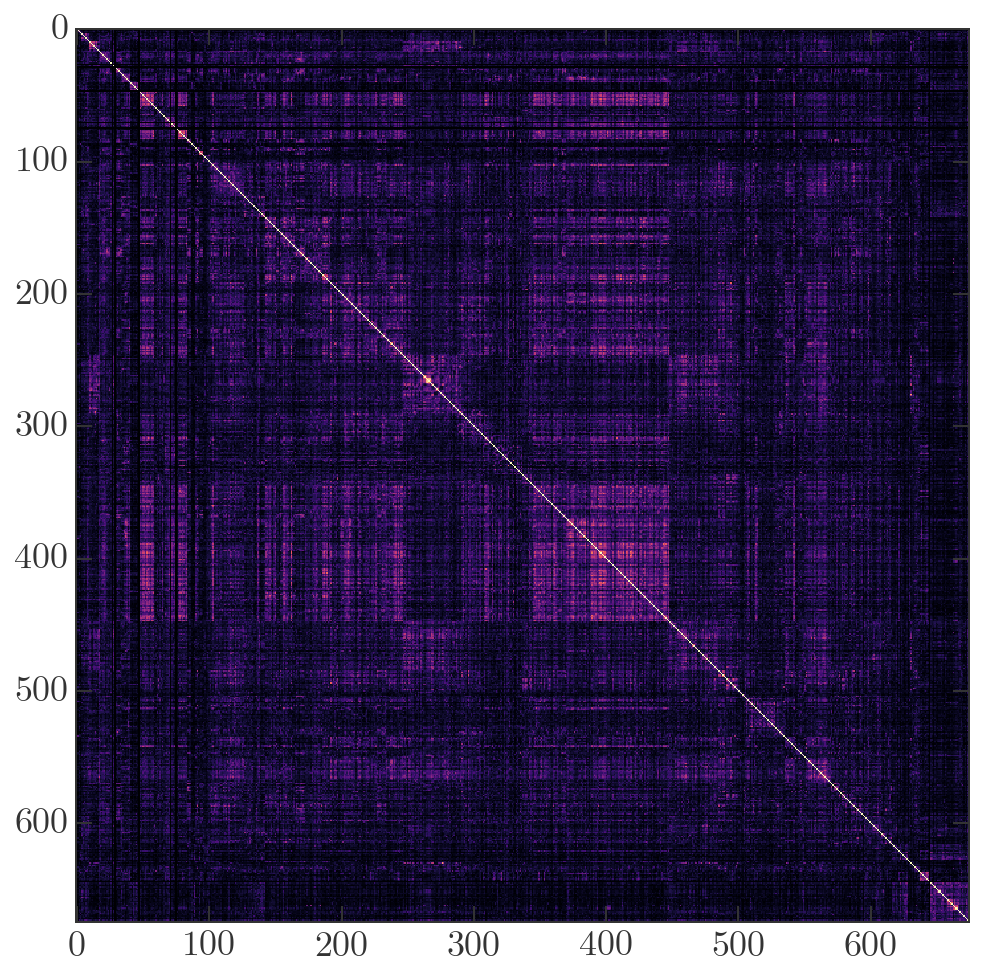

In [24]:
pl.figure(figsize=(8,8))
vmax = similarity_matrix[similarity_matrix < 0.99].max()
pl.imshow(similarity_matrix, cmap='magma', interpolation='nearest',
          vmax=vmax)

We can find the top ten most similar abstracts by sorting the values, but because this matrix is symmetric we can consider just the upper triangle of the matrix. Here we get the indices of the top ten most similar abstracts, excluding values equal to 1 (e.g., along the diagonal):

In [25]:
triu_similarity_matrix = np.triu(similarity_matrix)
similarity_matrix_1d = triu_similarity_matrix.ravel()
sorted_sim = np.sort(similarity_matrix_1d[~np.isclose(similarity_matrix_1d, 1.)])[::-1]

most_similar_idx = np.where((triu_similarity_matrix >= sorted_sim[9]) & 
                            (~np.isclose(similarity_matrix, 1.)))
most_similar_idx = np.vstack(most_similar_idx).T

Here are the top ten most similar abstracts printed back-to-back:

In [26]:
for ix1,ix2 in most_similar_idx:
    pres1 = presentation_df.iloc[ix1]
    pres2 = presentation_df.iloc[ix2]
    print(pres1['title'])
    print(pres2['title'])
    print()

Constraining the atmosphere of exoplanet WASP-34b
Analysis of Secondary Eclipse Observations of Hot-Jupiters WASP-26b and CoRoT-1b

Constraining the atmosphere of exoplanet WASP-34b
Atmospheric, Orbital and Secondary Eclipse Analysis of HAT-P-30-WASP-51b

Constraining the atmosphere of exoplanet WASP-34b
Secondary Eclipse Observations and Orbital Analysis of WASP-32b

Analysis of Secondary Eclipse Observations of Hot-Jupiters WASP-26b and CoRoT-1b
Atmospheric, Orbital and Secondary Eclipse Analysis of HAT-P-30-WASP-51b

Analysis of Secondary Eclipse Observations of Hot-Jupiters WASP-26b and CoRoT-1b
Secondary Eclipse Observations and Orbital Analysis of WASP-32b

Atmospheric, Orbital and Secondary Eclipse Analysis of HAT-P-30-WASP-51b
Secondary Eclipse Observations and Orbital Analysis of WASP-32b

How Giant Planets Shape the Characteristics of Terrestrial Planets
The Fragility of the Terrestrial Planets During a Giant Planet Instability

Galaxy Structure as a Driver of the Star Format

That seems reasonable! However, many of these are in the same sessins. We will now look at which simultaneous sessions have the most overlap. For now, we'll just look at sessions on or after the first day of conference talks (5 Jan), and we'll only check for sessions that have the same start time (we should really check for sessions that overlap in time, but...this is a hack...). To start, we'll define a metric for assessing how similar two *sessions* are: for now, we'll assume that astronomers don't move between sessions (e.g., once they are at a session, they stay for all talks) and we'll define the session similarity as the maximum similarity between all pairs of presentations between two simultaneous sessions:

In [27]:
from sklearn.utils.extmath import cartesian

def session_similarity(so_id1, so_id2):
    """
    Getting the sub-matrix of the similarity matrix for all pairs 
    of presentations between two session ID's.
    """
    presentations_session1 = presentation_df[presentation_df['so_id'] == so_id1]
    presentations_session2 = presentation_df[presentation_df['so_id'] == so_id2]
    
    if len(presentations_session1) == 0 or len(presentations_session2) == 0:
        # no presentations in session
        return np.array([])
    
    index_pairs = cartesian((presentations_session1.index,presentations_session2.index)).T
    sub_matrix = similarity_matrix[(index_pairs[0],index_pairs[1])]
    
    shape = (len(presentations_session1), len(presentations_session2))
    sub_matrix = sub_matrix.reshape(shape)
    
    return sub_matrix

Here we group the sessions by start time and within each group we find the two sessions that overlap the most:

In [28]:
grouped_sessions = session_df[session_df['start_date_time'] >= datetime(2016, 1, 5)].groupby('start_date_time')

for start_time,group in grouped_sessions:
    titles = []
    max_scores = []
    for title1,so_id1 in zip(group['title'],group['so_id']):
        for title2,so_id2 in zip(group['title'],group['so_id']):
            if so_id1 >= so_id2: continue # only fill the upper triangle
            
            # similarity between all pairs of presentations between the two sessions
            scores = session_similarity(so_id1, so_id2)
            
            if scores.size == 0: # no presentations in one of the sessions
                continue 
            
            max_scores.append(scores.max())
            titles.append([title1, title2])
    
    if len(max_scores) < 1:
        continue
    
    print(start_time) # the start_time
    max_idx = np.argmax(max_scores)
    for t in titles[max_idx]:
        print(t)
    print(max_scores[max_idx])
    print()

2016-01-05 10:00:00
Intergalactic Medium, QSO Absorption Line Systems
Gas and Dust Content in Distant Galaxies
0.570158254448

2016-01-05 14:00:00
Extrasolar Planet Detection: Results from Kepler and K2
Stars II: Red Dwarfs and Brown Dwarfs
0.47690575599

2016-01-06 10:00:00
Young Stellar Objects, Very Young Stars
Elliptical and Spiral Galaxies II
0.458647725778

2016-01-06 14:00:00
Dark Energy Survey Early Results
Cosmology, CMB, and Dark Matter I
0.432562818444

2016-01-07 10:00:00
SDSS-IV MaNGA: Mapping Nearby Galaxies at Apache Point Observatory
The REsolved Spectroscopy Of a Local VolumE (RESOLVE) Survey and its Environmental COntext (ECO)
0.522251721857

2016-01-07 14:00:00
Star Formation
Starburst Galaxies II
0.369896548939

2016-01-08 10:00:00
Physical Properties of High Redshift Galaxies
Structure and Physics of Galaxies at z<~0.2
0.596678120671

2016-01-08 14:00:00
The Milky Way, Stellar Populations
Star-Forming Galaxies at z~0.3-1.0
0.475509239231



There it is! Even by title, it seems like most of these pairs would have some overlap in terms of scheduled talks. I hope to take this proof-of-concept and expand this into a tool that will help the AAS organizers plan the talk schedule to in a way that minimizes topic overlap. More to come soon! (well, after I finish my thesis...)